In [1]:
#required imports
from sklearn.neural_network import MLPRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  
from math import sqrt 
from sklearn.metrics import confusion_matrix
import datetime
import warnings
warnings.filterwarnings('ignore')
from dateutil.parser import parse
from datetime import timedelta,datetime,date

FEATURES_FILE="../Data_Preparation/KingsCross_SlidingWindow_48hours.csv"
WEEKDAYS = ["monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

In [2]:
features = pd.read_csv(FEATURES_FILE)
features["Date"] = features["New Date"]
del features["New Date"]
for c in features.columns:
    print(c)

StartStation Id
Current Usage
Usage0
Usage1
Usage2
Usage3
Usage4
Usage5
Usage6
Usage7
Usage8
Usage9
Usage10
Usage11
Usage12
Usage13
Usage14
Usage15
Usage16
Usage17
Usage18
Usage19
Usage20
Usage21
Usage22
Usage23
Usage24
Usage25
Usage26
Usage27
Usage28
Usage29
Usage30
Usage31
Usage32
Usage33
Usage34
Usage35
Usage36
Usage37
Usage38
Usage39
Usage40
Usage41
Usage42
Usage43
Usage44
Usage45
Usage46
Usage47
Usage 48 Avg. over 6h
Usage 49 Avg. over 6h
Usage 50 Avg. over 6h
Usage 51 Avg. over 6h
Future0
Future1
Future2
Future3
Future4
Future5
Future6
Future7
Future8
Future9
Future10
Future11
Future12
Future13
Future14
Future15
Future16
Future17
Future18
Future19
Future20
Future21
Future22
Future23
Current Temperature
temp0
temp1
temp2
temp3
temp4
temp5
temp6
temp7
temp8
temp9
temp10
temp11
temp12
temp13
temp14
temp15
temp16
temp17
temp18
temp19
temp20
temp21
temp22
temp23
temp24
temp25
temp26
temp27
temp28
temp29
temp30
temp31
temp32
temp33
temp34
temp35
temp36
temp37
temp38
temp39
temp40
temp4

In [3]:
features.head()

,StartStation Id,Current Usage,Usage0,Usage1,Usage2,Usage3,Usage4,Usage5,Usage6,Usage7,...,wind43,wind44,wind45,wind46,wind47,wind 48 Avg. over 6h,wind 49 Avg. over 6h,wind 50 Avg. over 6h,wind 51 Avg. over 6h,Date
0,14,73,15,1,0,0,0,0,1,0,...,1.30,1.04,0.34,0.14,0.03,0.675000,0.523333,1.178333,0.645000,2015-01-06T07:00:00.000+01:00
1,14,136,73,15,1,0,0,0,0,1,...,1.02,1.30,1.04,0.34,0.14,0.770000,0.380000,1.096667,0.895000,2015-01-06T08:00:00.000+01:00
2,14,25,136,73,15,1,0,0,0,0,...,1.53,1.02,1.30,1.04,0.34,0.923333,0.286667,1.003333,1.098333,2015-01-06T09:00:00.000+01:00
3,14,2,25,136,73,15,1,0,0,0,...,1.36,1.53,1.02,1.30,1.04,0.961667,0.368333,0.938333,1.175000,2015-01-06T10:00:00.000+01:00
4,14,2,2,25,136,73,15,1,0,0,...,0.80,1.36,1.53,1.02,1.30,1.065000,0.483333,0.703333,1.268333,2015-01-06T11:00:00.000+01:00


In [4]:
holidays = pd.read_csv("../raw/UK Bank Holidays.csv")
holidays.rename({"Bank Holiday":"Holiday"}, inplace=True)
del holidays["Name"]
holidays.head()

,Bank Holiday,Date
0,1,2009-01-01
1,0,2009-01-25
2,0,2009-01-27
3,0,2009-02-14
4,0,2009-02-24


In [5]:
MARGIN_HOURS = 4 # if 6 from 0:00-6:00 to 24:00-6:00 -> 18:00 to 18:00

# First filling a holidays dictionnary:
holidays_dico = {}
for index, row in holidays.iterrows():
    if row["Bank Holiday"] == 1:
        today = parse(row["Date"])
        holidays_dico[today] = True

# Detect if datetime is in [day - MARGIN_HOURS;day + 1 - MARGIN_HOURS[ :
holiday_array = []
for index, row in features.iterrows():
    now = parse(row["Date"])
    today = datetime(now.year,now.month,now.day)
    if now.hour >= 24 - MARGIN_HOURS:
        today = today + timedelta(1)
    holiday_array.append(holidays_dico.get(today,False))
    
features["Bank Holiday"]  = holiday_array
features[features["Bank Holiday"] == True].head()

,StartStation Id,Current Usage,Usage0,Usage1,Usage2,Usage3,Usage4,Usage5,Usage6,Usage7,...,wind44,wind45,wind46,wind47,wind 48 Avg. over 6h,wind 49 Avg. over 6h,wind 50 Avg. over 6h,wind 51 Avg. over 6h,Date,Bank Holiday
2091,14,1,5,5,6,5,7,3,8,9,...,5.79,7.20,7.10,7.26,7.665000,7.491667,6.065000,6.425000,2015-04-02T20:00:00.000+02:00,True
2092,14,3,1,5,5,6,5,7,3,8,...,5.29,5.79,7.20,7.10,7.213333,7.881667,5.966667,6.258333,2015-04-02T21:00:00.000+02:00,True
2093,14,2,3,1,5,5,6,5,7,3,...,5.91,5.29,5.79,7.20,6.861667,7.841667,6.408333,6.006667,2015-04-02T22:00:00.000+02:00,True
2094,14,0,2,3,1,5,5,6,5,7,...,6.26,5.91,5.29,5.79,6.356667,7.993333,6.603333,5.891667,2015-04-02T23:00:00.000+02:00,True
2095,14,2,0,2,3,1,5,5,6,5,...,5.59,6.26,5.91,5.29,5.988333,7.945000,6.781667,6.015000,2015-04-03T00:00:00.000+02:00,True


In [6]:
def parse_date(s):
    date = s.split("T")[0].split("-")
    hour = s.split("T")[1].split(":")[0]
    return datetime(int(date[0]),int(date[1]),int(date[2]),int(hour))
features["Month"] = features["Date"].map(lambda x: parse_date(x).month)
features["Day"] = features["Date"].map(lambda x: parse_date(x).day)
features["Weekday"] = features["Date"].map(lambda x: parse_date(x).weekday())
features["Hour"] = features["Date"].map(lambda x: parse_date(x).hour)
del features["Date"]

In [7]:
from collections import defaultdict
cleanup_nums = {"clear-day": 1, "clear-night": 1, "partly-cloudy-day": 2, "partly-cloudy-night": 2,"cloudy":3,"wind":4, "rain": 5, "fog": 6, "snow": 7, "sleet": 7, 'nan': 1}
cleanup_nums = defaultdict(lambda: 1, cleanup_nums)
for i in range(48):
    features["sum" + str(i)] = features["sum" + str(i)].map(lambda x: cleanup_nums[x])

features["Current Summary"] = features["Current Summary"].map(lambda x: cleanup_nums[x])
features["sum0"].head()

0    1
1    1
2    1
3    1
4    1
Name: sum0, dtype: int64

In [8]:
features = features.fillna(0)

In [9]:
features.tail()

,StartStation Id,Current Usage,Usage0,Usage1,Usage2,Usage3,Usage4,Usage5,Usage6,Usage7,...,wind47,wind 48 Avg. over 6h,wind 49 Avg. over 6h,wind 50 Avg. over 6h,wind 51 Avg. over 6h,Bank Holiday,Month,Day,Weekday,Hour
36816,14,4,8,1,3,0,7,5,0,3,...,14.81,24.918333,22.633333,17.976667,11.708333,False,3,17,6,19
36817,14,2,4,8,1,3,0,7,5,0,...,14.95,24.411667,23.155000,19.191667,11.555000,False,3,17,6,20
36818,14,3,2,4,8,1,3,0,7,5,...,13.27,22.998333,24.263333,19.355000,12.120000,False,3,17,6,21
36819,14,1,3,2,4,8,1,3,0,7,...,9.43,21.190000,24.810000,19.691667,13.293333,False,3,17,6,22
36820,14,1,1,3,2,4,8,1,3,0,...,9.43,19.196667,25.325000,20.726667,14.625000,False,3,17,6,23


In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36821 entries, 0 to 36820
Columns: 295 entries, StartStation Id to Hour
dtypes: bool(1), float64(167), int64(127)
memory usage: 82.6 MB


In [11]:
features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
StartStation Id,36821.0,14.000000,0.000000,14.0,14.000000,14.000000,14.000000,14.00
Current Usage,36821.0,10.777220,26.256613,0.0,1.000000,3.000000,8.000000,298.00
Usage0,36821.0,10.776378,26.257035,0.0,1.000000,3.000000,8.000000,298.00
Usage1,36821.0,10.777600,26.256572,0.0,1.000000,3.000000,8.000000,298.00
Usage2,36821.0,10.777518,26.256601,0.0,1.000000,3.000000,8.000000,298.00
Usage3,36821.0,10.777464,26.256621,0.0,1.000000,3.000000,8.000000,298.00
Usage4,36821.0,10.779800,26.255825,0.0,1.000000,3.000000,8.000000,298.00
Usage5,36821.0,10.777953,26.256426,0.0,1.000000,3.000000,8.000000,298.00
Usage6,36821.0,10.780397,26.255640,0.0,1.000000,3.000000,8.000000,298.00
Usage7,36821.0,10.782760,26.255022,0.0,1.000000,3.000000,8.000000,298.00


In [12]:
#Feature Matrix with past and today data
cols = features.columns
cols = filter(lambda x: x[:6] != "Future", cols)
X=features.loc[:,cols]
X.head()

,StartStation Id,Current Usage,Usage0,Usage1,Usage2,Usage3,Usage4,Usage5,Usage6,Usage7,...,wind47,wind 48 Avg. over 6h,wind 49 Avg. over 6h,wind 50 Avg. over 6h,wind 51 Avg. over 6h,Bank Holiday,Month,Day,Weekday,Hour
0,14,73,15,1,0,0,0,0,1,0,...,0.03,0.675000,0.523333,1.178333,0.645000,False,1,6,1,7
1,14,136,73,15,1,0,0,0,0,1,...,0.14,0.770000,0.380000,1.096667,0.895000,False,1,6,1,8
2,14,25,136,73,15,1,0,0,0,0,...,0.34,0.923333,0.286667,1.003333,1.098333,False,1,6,1,9
3,14,2,25,136,73,15,1,0,0,0,...,1.04,0.961667,0.368333,0.938333,1.175000,False,1,6,1,10
4,14,2,2,25,136,73,15,1,0,0,...,1.30,1.065000,0.483333,0.703333,1.268333,False,1,6,1,11


In [13]:
y_tests = []
X_test = None
preds = []
NB_HOURS = 24

for i in range(NB_HOURS):
    print(i)
    #target variable
    y = features['Future' + str(i)].tolist()
    #Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    mlp = MLPRegressor(
    hidden_layer_sizes=(10,5),  activation='relu', solver='lbfgs', alpha=0.001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    m = mlp.fit(X_train_scaled,y_train)
    predictions = m.predict(X_test_scaled)
    
    y_tests.append(y_test)
    preds.append(predictions)
    
    #Print scores
    print("Training set score: %f" % m.score(X_train_scaled, y_train))
    print("Test set score: %f" % m.score(X_test_scaled, y_test))
    
    #Compare predicted and actual values
    #df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})  
    #print(df.head())


0
Training set score: 0.959244
Test set score: 0.923155
1
Training set score: 0.948781
Test set score: 0.824716
2
Training set score: 0.947154
Test set score: 0.838579
3
Training set score: 0.943464
Test set score: 0.816942
4
Training set score: 0.953550
Test set score: 0.833399
5
Training set score: 0.951495
Test set score: 0.817034
6
Training set score: 0.925512
Test set score: 0.839422
7
Training set score: 0.923083
Test set score: 0.844903
8
Training set score: 0.956186
Test set score: 0.830336
9
Training set score: 0.939290
Test set score: 0.808723
10
Training set score: 0.954362
Test set score: 0.827385
11
Training set score: 0.944907
Test set score: 0.771973
12
Training set score: 0.950613
Test set score: 0.793764
13
Training set score: 0.946266
Test set score: 0.774024
14
Training set score: 0.952359
Test set score: 0.765782
15
Training set score: 0.939541
Test set score: 0.785340
16
Training set score: 0.934030
Test set score: 0.767024
17
Training set score: 0.945883
Test set 

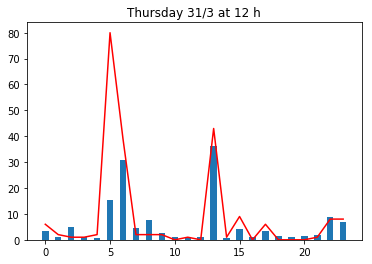

In [14]:
plt.plot(list(range(NB_HOURS)),list(map(lambda x:x[0],y_tests)), color="red")
plt.bar(list(range(NB_HOURS)),list(map(lambda x:x[0],preds)), 0.5)

def set_datetime_title(dataset, index):
    plt.title("%s %s/%s at %s h" % (WEEKDAYS[dataset.iloc[index]["Weekday"]], dataset.iloc[index]["Day"],dataset.iloc[index]["Month"],dataset.iloc[index]["Hour"]))

set_datetime_title(X_test,0)

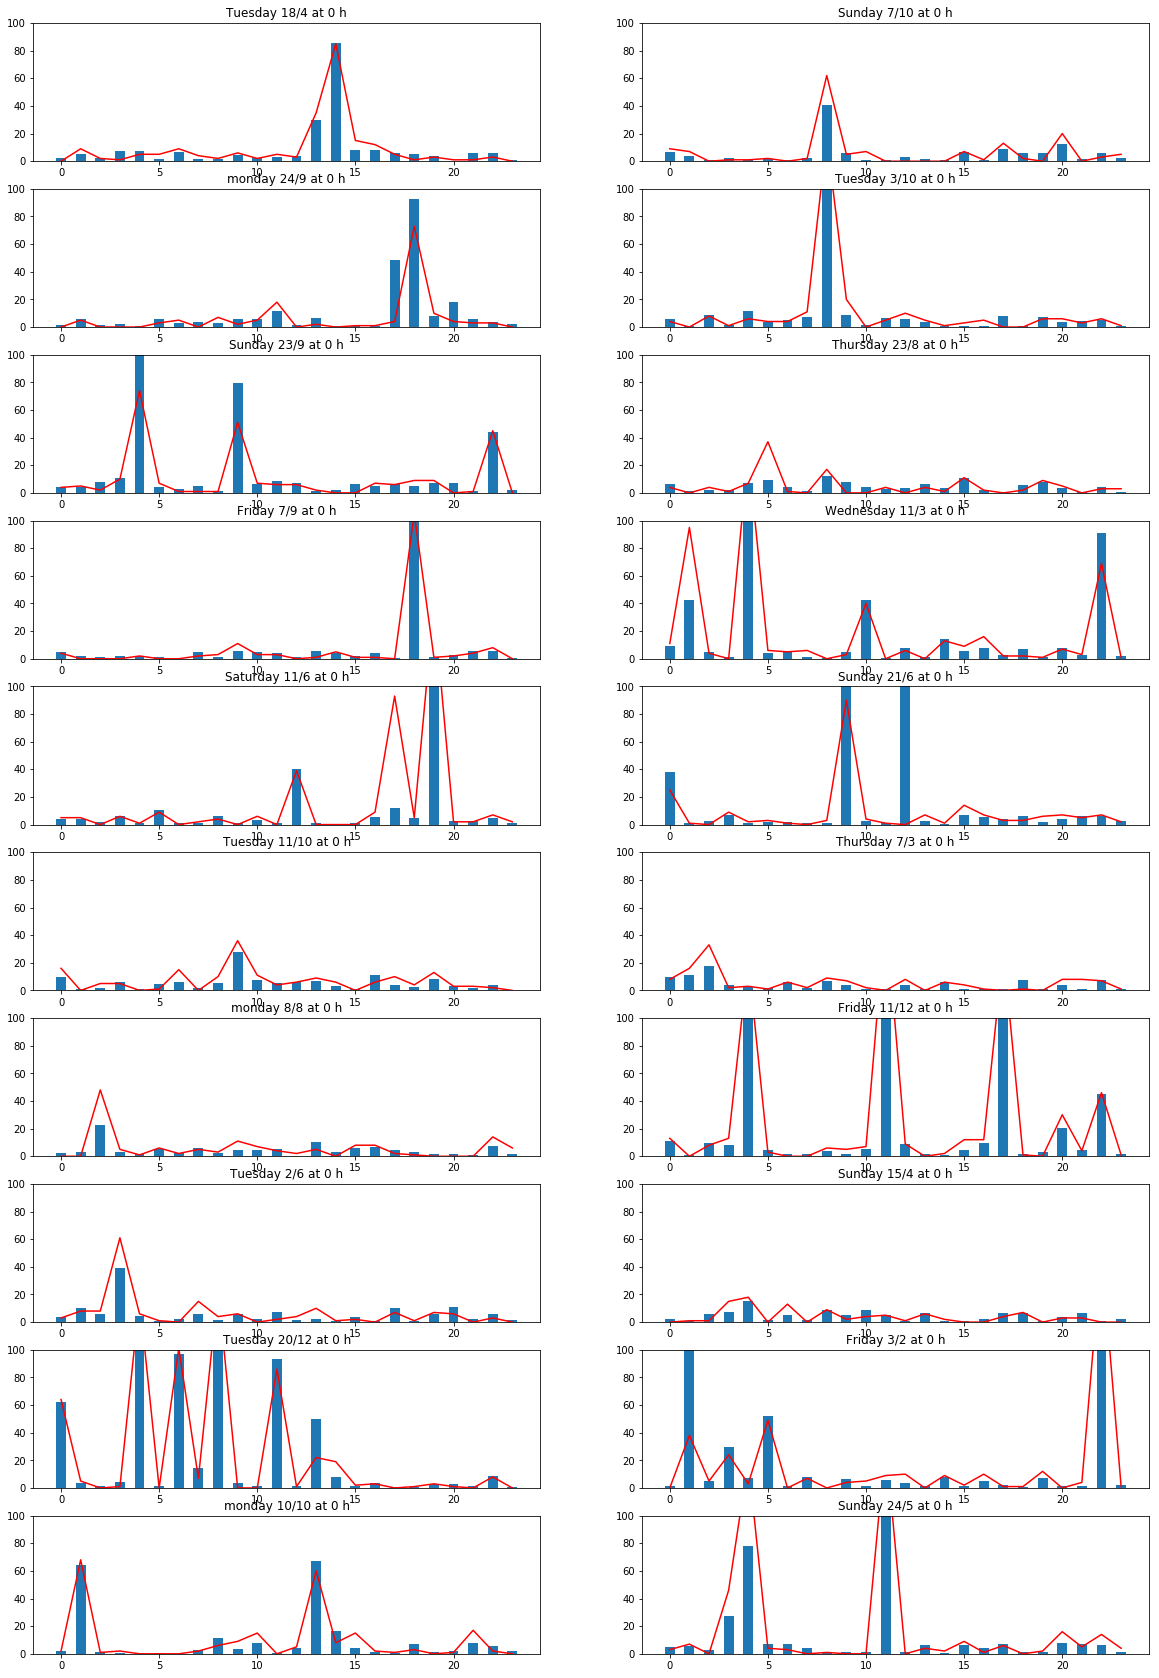

In [15]:
from random import randrange
length = 20
width = 2
height = length / width + length % width

plt.figure(figsize=(20,30))

STARTING_HOUR = 0

for i in range(length):
    j = randrange(len(y_tests[0]))
    while X_test.iloc[j]["Hour"] != STARTING_HOUR:
        j = randrange(len(y_tests[0]))
    plt.subplot(height, width, i + 1)
    plt.plot(list(range(NB_HOURS)),list(map(lambda x:x[j],y_tests)), color="red")
    plt.bar(list(range(NB_HOURS)),list(map(lambda x:x[j],preds)), 0.5)
    set_datetime_title(X_test,j)
    plt.ylim([0,100])

plt.show()

## Accuracy
Recommended from [Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)<br>
```python
score(X, y, sample_weight=None)
```
Returns the coefficient of determination R^2 of the prediction.

The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.


In [16]:
#Returns the coefficient of determination R^2 of the prediction
"The accuracy of the model is {0:.7f}".format(mlp.score(X_train_scaled,y_train))

'The accuracy of the model is 0.9429427'